# Week 2 - Convolution (or filtering)

We are going to use images in the form of multidimensional arrays of data (a 2D matrix for a grayscale image and  3 2D matrices in case of a RGB image) and the kernel will be a 2D matrix (usually square with an odd number of rows/columns). Therefore, we will talk about 2D convolution.

If we have our input image $f_{in}$ and a kernel K, the convolution is defined by:

$$f_{out}(x,y)=K*f_{in}(x,y)= \sum_{s}\sum_{t}K(s,t)f_{in}(x-s,y-t)$$

where $f_{out}(x,y)$ is the value of the pixel $(x,y)$ of the output image $f_{out}$.
In this exercise we are going to consider **cross correlation** as a simplified technique of the convolution.

Note: Cross correlation is implemented in a lot of machine learning libraries (as Pytorch and Tensorflow) and many times they called it **convolution**. DON'T GET CONFUSED!!! In that case you need to flip the kernel :)

Cross correlation only considers the sum of the elementwise product between the kernel and the sub-image region considered. Formally, this is defined as:

$$f_{out}(x,y)=K\star f_{in}(x,y)= \sum_{s}\sum_{t}K(s,t)f_{in}(x+s,y+t)$$

The following GIF shows how to perform the cross-correlation between an image and a kernel:

![alt text](3D_Convolution_Animation.gif "Cross correlation")




## Exercise 1: Understanding convolution
In general for the exercises:

- *Italics indicate text to explain the motivation or process behind a task*

- **Bold text indicates a task**

- Finally, \* (one star) and ** (two stars) indicates a difficult or a particuarly difficult task, respectively. These are especially optional!

Firstly we will run some code to load an image

In [1]:
from ctypes import c_char

import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as scipy_conv2d
from os.path import join
from time import time

Load the image

In [2]:
image_gray = np.array(Image.open(join('images', 'kb_grayscale.jpg')))
print(image_gray.shape)

(720, 1080)


Define a function to show images 

In [3]:
def show_image(image, name='', cmap='gray', show=True, vmin=0, vmax=255):
    plt.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(name)
    plt.axis('off')
    plt.tight_layout()
    if show:
        plt.show()

**1. Inspect the following code where np.pad is used to pad the image. Change the values of the padding_size variable to get an understanding of which value relates to which dimension.**

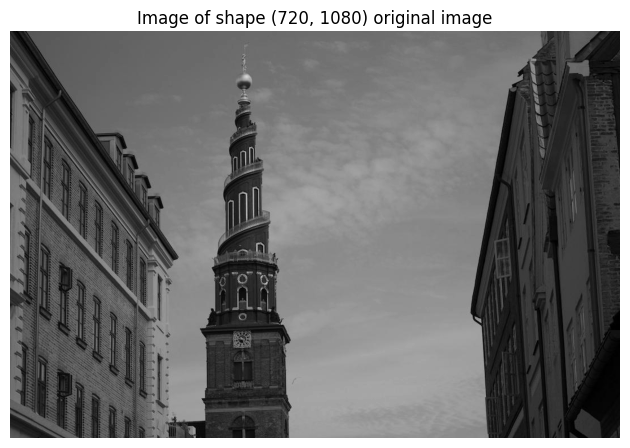

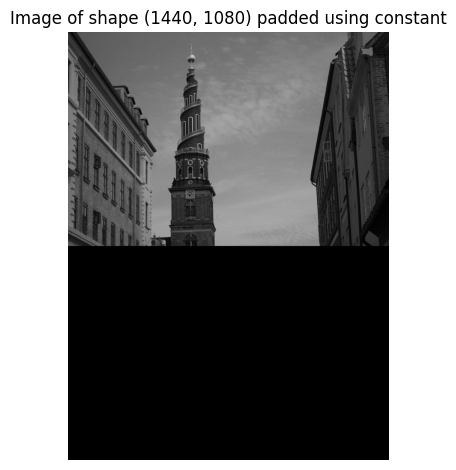

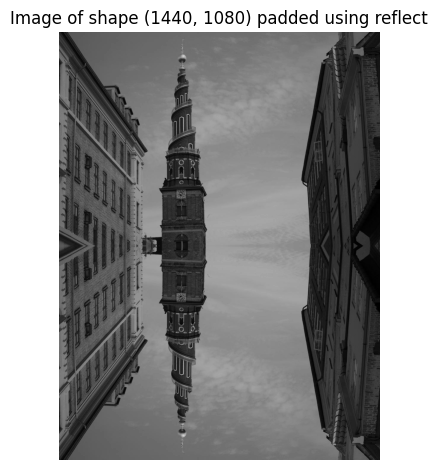

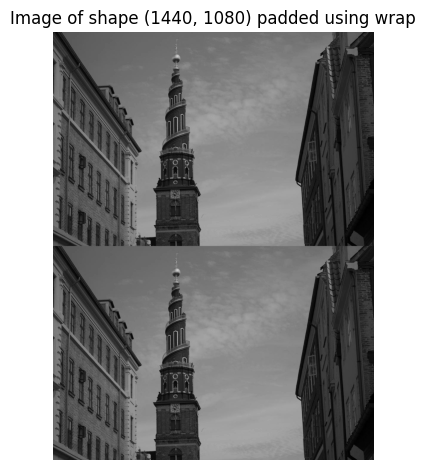

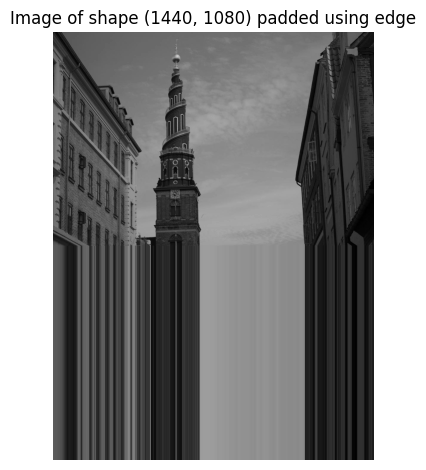

In [4]:
padding_size = [[0, 720], [0, 0]] # ((top, bottom), (left, right))
# Sadly the variable arguments for np.pad make a loop possible but ugly
image_padded_constant = np.pad(image_gray, padding_size, mode='constant', constant_values=0)
image_padded_reflect = np.pad(image_gray, padding_size, mode='reflect', )
image_padded_wrap = np.pad(image_gray, padding_size, mode='wrap')
image_padded_edge = np.pad(image_gray, padding_size, mode='edge')

show_image(image_gray, name=f'Image of shape {image_gray.shape} original image')
show_image(image_padded_constant, name=f'Image of shape {image_padded_constant.shape} padded using constant')
show_image(image_padded_reflect, name=f'Image of shape {image_padded_reflect.shape} padded using reflect')
show_image(image_padded_wrap, name=f'Image of shape {image_padded_wrap.shape} padded using wrap')
show_image(image_padded_edge, name=f'Image of shape {image_padded_edge.shape} padded using edge')

**2. Time to implement your own convolution function, it should do a valid convolution. Remember to flip the kernel!! (\*Optional)**
*A valid convolution does not apply any padding to the input image*

In [5]:
# If you at any point get stuck or just want to continue with the other exercises, just copy the solution:)
def convolution2d(image, kernel):
    assert kernel.shape[0] % 2 == 1 and kernel.shape[1] % 2 == 1, 'kernel must be an odd number for this convolution function'
    global kernel_height, kernel_width
    # Flip the kernel
    kernel = np.flipud(np.fliplr(kernel))
    
    # Get the dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Compute the output dimensions
    stride = 1
    output_height = int((image_height-kernel_height+1)/stride)
    output_width = int((image_width-kernel_width+1)/stride)
    
    # Initialize the output matrix
    output = np.zeros((output_height, output_width))
    
    # Perform 2D convolution
    for i in range(output_height):
        for j in range(output_width):
            s = 0
            for v in range(kernel_width):
                for u in range(kernel_height):
                    s += kernel[u, v]*image[i+u, j+v]
            output[i,j] = s
    
    return output

*Use the cell below to test your implementation and the next cell to compare your implementation to scipy's*

In [6]:
# First example from group discussion:
print("w (kernel):")
w       = np.array([[1,2,1]])
print(w)
print("input array:")
f_in  = np.array([[0,1,0],[0,2,0],[0,3,0]])
print(f_in)
f_out = convolution2d(f_in,w)
print("valid output:")
print(f_out)
print("f_in zero padded:")
f_padded = np.pad(f_in, [(0, 0), (1,1)], constant_values=0)
print(f_padded)
f_out_padded   = convolution2d(f_padded, w) # note here that we use scipy's implementation since our's do zero padding.
print("zero padded after convolution:")
print(f_out_padded)

w (kernel):
[[1 2 1]]
input array:
[[0 1 0]
 [0 2 0]
 [0 3 0]]
valid output:
[[2.]
 [4.]
 [6.]]
f_in zero padded:
[[0 0 1 0 0]
 [0 0 2 0 0]
 [0 0 3 0 0]]
zero padded after convolution:
[[1. 2. 1.]
 [2. 4. 2.]
 [3. 6. 3.]]


In [7]:
# Validate that our implementation matches scipy's
f_out_scipy = scipy_conv2d(f_in,w,mode="valid")
f_out_scipy_padded = scipy_conv2d(f_in,w,mode="same")

print(f'Difference between own convolution and scipy:\n'
      f'\t\t\t\tScipy\tOwn\n'
      f'Shape valid:\t{f_out.shape}, {f_out_scipy.shape}\n'
      f'Diff valid: {np.sum(f_out - f_out_scipy)}\n'
      f'Shape same:\t\t{f_out_padded.shape}, {f_out_scipy_padded.shape}\n'
      f'Diff same: {np.sum(f_out_padded - f_out_scipy_padded)}\n'
      )

Difference between own convolution and scipy:
				Scipy	Own
Shape valid:	(3, 1), (3, 1)
Diff valid: 0.0
Shape same:		(3, 3), (3, 3)
Diff same: 0.0



## Exercise 2: Kernel design


You should use the 2D convolution function from the previous exercise to compute the convolution between the image you loaded before and some simple kernels/filters that can make the image blurry or sharp and can be used to highlight the edges.  

- The first filter is blurry filter, in its 3x3 shape, this is given by the following matrix:

  $$ F_{blurry} = \frac{1}{9} \left[ {\begin{array}{ccc} 1&1&1\\1&1&1\\1&1&1 \end{array}} \right] $$
                                   
    where the normalization factor is computed by $\frac{1}{\sum_{i,j}F_{i,j}}$.

    - In case the image is a high-definition image, we suggest you to create a larger filter to actually see the blurrying effect (try 7x7 or 11x11)!
 **1. Why does this kernel blur the image?**
  

We need a function to translate the image to floats in the range (0, 1):

In [8]:
def img_as_float(image):
    return image / 255.0

In [9]:
img_float = img_as_float(image_gray)
# Implement the kernel for F_blurry
F_blurry = (1/121)*np.ones((11, 11))
# F_blurry[kernel_height//2, kernel_width//2] = 1/9
# F_blurry

**2. Apply your convolution function to the image using the blurry kernel **

In [10]:
img_float_padded = np.pad(img_float, ((1,1), (1,1)), constant_values=0)
t = time()
# img_blur = convolution2d(img_float_padded, F_blurry)
time_own = time() - t
# show_image(img_blur, name='blurry', vmin=0, vmax=1)

*It is all well and good to write nice functions that do the job, but if a third party library for python can do the same thing, chances are they do it significantly faster than your own.
As an illustration for why you should use libraries and not your own implementations in most cases notice the difference in run time between the two (and we will use scipy's from now on):* 

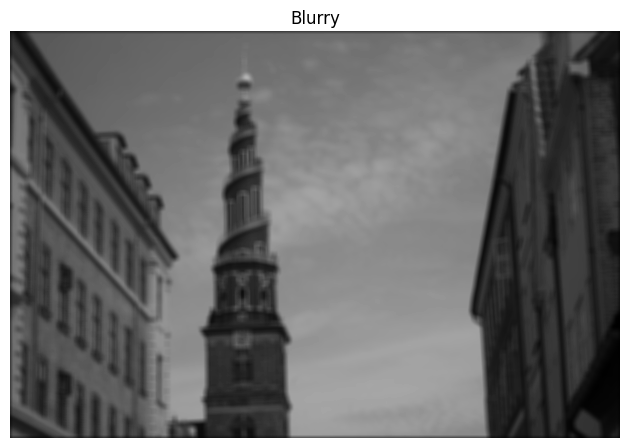

In [11]:
t = time()
img_blur = scipy_conv2d(img_float, F_blurry, mode='same')
time_scipy = time() - t
show_image(img_blur, name='Blurry', vmin=0, vmax=1)
# print(f'Own took {time_own:.4f}, Scipy took {time_scipy:.4f}, so {time_scipy/time_own * 100: .2f} % of your implementation')

**3. \*See if you can improve and optimise your own implementation to reduce the gap between the two.**

**4. Implement the following two filters:**

- The second filter you are going to apply is used to sharpen the image, this is given by:

  $$ F_{sharp} = \left[ {\begin{array}{ccc}0&-1&0\\-1&7&-1\\0&-1&0\end{array}} \right] $$ 

In [12]:
# Implement the kernel for F_sharp
F_sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
img_sharp = scipy_conv2d(img_float,F_sharp)

- The last filter is used to highlight the edges of the objects in the image. This filter is an approximation of a Laplacian filter. The Laplacian is the measure of the 2nd derivative of an image. Therefore if we have an image with pixel intensity values $f_{in}(x,y)$, the Laplacian is given by $\frac{\partial^2 I}{\partial i^2} + \frac{\partial^2 I}{\partial j^2}$.

$$ F_{edge} = \left[ {\begin{array}{ccc}0&1&0\\1&-4&1\\0&1&0\end{array}} \right] $$ 
         

In [13]:
# Implement the kernel for F_edge
F_edge  = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

img_edge = scipy_conv2d(img_float,F_edge)

*Here are some suggestions for things you could test:*
- What happens if you run the sharpen filter on blurry image? Try it.
- Try to filter an image multiple time. What happens to the intensity lines?

**4. Look at the output of the image filtered with the sharpening kernel in the following cell and explain what you see.**
 
*Hint: Inspect the maximum value* 

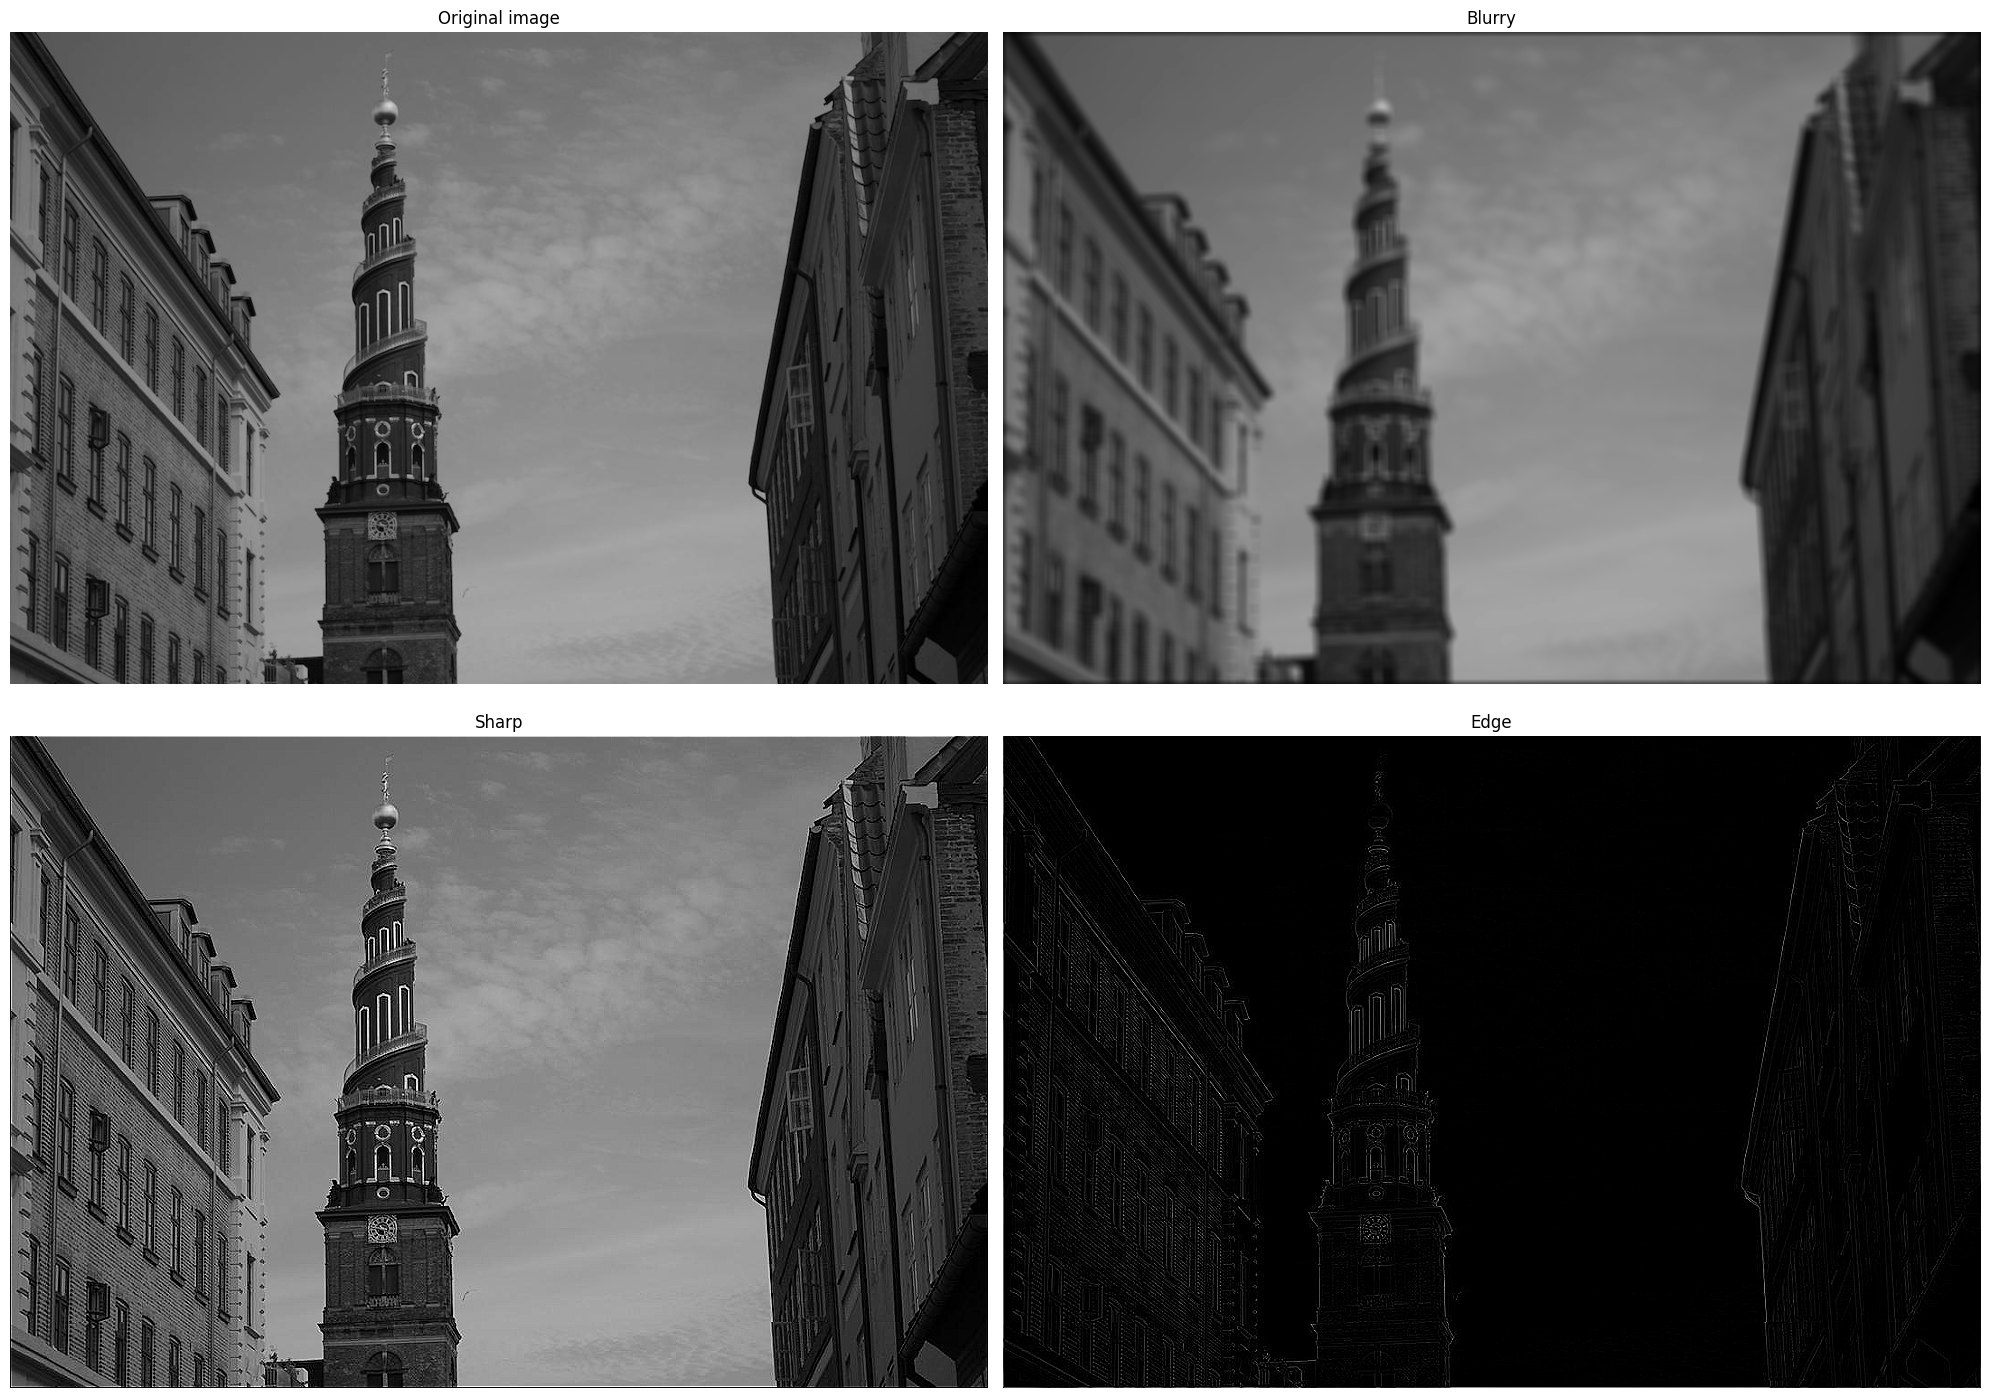

In [14]:
fig = plt.figure(figsize = (20,15))
plt.subplot(2,2, 1)
show_image(img_float, name='Original image', show=False, vmin=0, vmax=1)

plt.subplot(2,2, 2)
show_image(img_blur, name='Blurry', show=False, vmin=0, vmax=1)

plt.subplot(2,2,3)
# Notice that since the values of the sharpening filter have a sum greater than 1 and thus may result in pixel values greater than 1.
show_image(img_sharp, name='Sharp', show=False, vmin=0, vmax=1)

plt.subplot(2,2,4)
show_image(img_edge, name='Edge', show=False, vmin=0, vmax=1)

plt.show()

**5. Try increasing the kernel size for the blurring filter and compare the effects.**

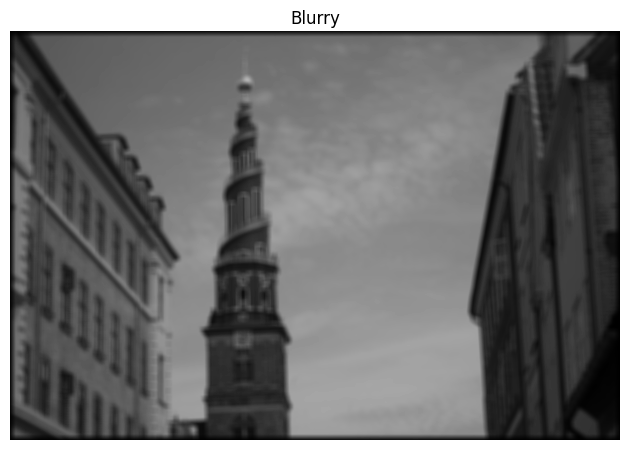

In [16]:
size = (11, 11)
F_blurry = 1/(11*11) * np.ones((11, 11))

img_blur = scipy_conv2d(img_float,F_blurry)

show_image(img_blur, name='Blurry', show=True, vmin=0, vmax=1)

**6. What happens to the image if we do not change the range to (0, 1) and use a kernel with values that do not sum to 1?**


In [ ]:
size = (?, ?)
F_blurry_large = ?

img_blur =scipy_conv2d(image_gray, F_blurry_large)

show_image(img_blur, name='Blurry with unnormalised kernel values', show=True, vmin=0, vmax=255)
print(img_blur.min(), img_blur.max())

## Exercise 3: Sobel filter

In this exercise you are going to apply a more sophisticated edge detection filter than the one you used in the previous exercise. We will apply a Sobel filter to the original image. The Sobel filter (also known as Sobel operator https://en.wikipedia.org/wiki/Sobel_operator) is composed by these two different filters:

$$ F_{v} = \left[ {\begin{array}{ccc}-1&0&1\\-2&0&2\\-1&0&1\end{array}} \right] $$ 
                                   
$$ F_{h} = \left[ {\begin{array}{ccc}-1&-2&-1\\0&0&0\\1&2&1\end{array}} \right] $$ 
                                  
These two filter, when convoluted with an image, are approximating the derivatives for the vertical and horizontal changes. Indeed, we have that we have that the value of the derivative is high when there is an high difference between neighbours pixels. And that is exactly where an edge is. 

If we denoted with $G_{v}$ and $G_{h}$ the resulting filtered images obtained by the convolution between $F_{v}$ and $F_{h}$ with the original image, we can use them to compute the approximation of the gradient for each point in the image by computing:

$$ G = \sqrt{ G_{v}^2 + G_{h}^2} $$


The code below does the following:
- Computes the two $G_{v}$ and $G_{h}$ filtered image and plot them. Comment on the resulting plots.
- Computes G and plot it. Compare the plot obtained by using this approach and the one using the single filter in previous the exercise.


In [ ]:
sobel_kernel_v = ?
sobel_kernel_h = ?

G_v = scipy_conv2d(img_float,sobel_kernel_v)
G_h = scipy_conv2d(img_float,sobel_kernel_h)
G   = ?

show_image(G_v, name='Sobel vertical convolution' , vmin=0, vmax=1)
show_image(G_h, name='Sobel horizontal convolution', vmin=0, vmax=1)
show_image(G, name='Edge enhancement combining the two sobel', vmin=0, vmax=1)

## Exercise 4 RGB images
Now we shall see, that the techniques you just used for grayscale images are also applicable to color images, but instead the convolution is done for each color dimension (One could also imagine applications where we apply a 3D filter to the image, treating the channels as a 3rd dimension).

**1. Apply the filters from exercise 3 to the different channels of the following RGB image:**

In [ ]:
img_rgb = np.array(Image.open((join('images', 'field.png')))) # load image
print(np.shape(img_rgb))
show_image(img_rgb, ('Original RGB image'))

In [ ]:
#filter the image, up to you which filters to use where
r_filter = ?
g_filter = ?
b_filter = ?

# extract the three channels
r_channel = img_as_float(img_rgb[:, :, 0])
g_channel = img_as_float(img_rgb[:, :, 1])
b_channel = img_as_float(img_rgb[:, :, 2])

r_fil = scipy_conv2d(r_channel,r_filter)
g_fil = scipy_conv2d(r_channel,g_filter)
b_fil = scipy_conv2d(r_channel,b_filter)

fig = plt.figure(figsize = (20, 30))

plt.subplot(4, 2, 1)
show_image(r_channel, cmap='Reds', vmin=0, vmax=1, name='Red channel', show=False)
plt.subplot(4, 2, 2)
show_image(r_fil, cmap='Reds', vmin=0, vmax=1, name='Red channel after convolution', show=False)

plt.subplot(4, 2, 3)
show_image(r_channel, cmap='Greens', vmin=0, vmax=1, name='Green channel', show=False)
plt.subplot(4, 2, 4)
show_image(r_fil, cmap='Greens', vmin=0, vmax=1, name='Green channel after convolution', show=False)

plt.subplot(4, 2, 5)
show_image(r_channel, cmap='Blues', vmin=0, vmax=1, name='Blue channel', show=False)
plt.subplot(4, 2, 6)
show_image(r_fil, cmap='Blues', vmin=0, vmax=1, name='Blue channel after convolution', show=False)

plt.subplot(4, 2, 7)
channels = np.stack((r_channel, g_channel,b_channel,), axis=-1)
show_image(channels, name='Original image', cmap='viridis', show=False, vmin=0, vmax=1)

# adding the results of the convolutions
final = np.stack((r_fil, g_fil, b_fil), axis=-1)
plt.subplot(4, 2, 8)
show_image(final, cmap='viridis', vmin=0, vmax=1, name='All channels after convolution')

**2. What happens when you combine different filters on different channels?**

## 5. **A primer on (Cross)-Entropy

*This is an optional subject*

Entropy can often best be considered as a measure of uncertainty, or an expected degree of "surprise" in observing the outcome of a random variable. The formula, as unintuitive as it is, is the following:

$$H(X) = - \sum^{N}_{i = 1}p(X = x_i) \log_2(p(X = x_i))$$

(Note here, that we consider only the discrete case of entropy.) (Also note, we use $log_2$, which we will write as $\log$ from hereon out) This formula perhaps doesn't make much sense in and of itself, so instead it makes sense to consider the following example: We have our friend throw a fair six-sided die, which we then need to guess the result of using the least number of yes/no questions. Since the dice is fair, the best method here is constantly trying to **halve** the number of possible options the dice can land on. First by asking a question like *"Is the result 1, 2 or 3?"*. This strategy is illustrated below:

![](images/dice_throw_entropy.png)

As you can see, using this , we are sometimes lucky and get the correct answer after only 2 questions, however, somtimes we need to use 3. This brings us to the informal definition of entropy:  \ 

**Given that you ask the most informative questions possible, how many yes/no questions do you on average need to guess the result of random variable?**

Do note, when we say "**most informative questions**", we mean that we will always try to ask the questions that most quickly bring us to a correct guess of the random variable, even if this means just guessing a value right off the bat. For example if our friend used a a weighted die with a $50\%$ chance of landing on a 6, the most informative first question would be "*Is it 6?*" 


### Exercise 5.1

*It is exceptionally rare that we know the actual entropy of a random variable, but we can estimate it using samples, simply using the formula given above*

**1. Using the formula above, calculate the entropy of a fair, six-sided die**



**2. Likewise, calculate the entropy of a fair, eight-sided die, why does this result look as it does?**


**3. Explain how Entropy can be seen as a degree of "surprise" associated with the outcome of random variables**



**4. Complete the function in the cell below to calculate the empirical entropy of a random variable**

*Test your implementation by comparing with the theoretical bernoulli entropy plot, as shown two cells below*

In [ ]:
def empirical_entropy(random_variates):
    """
    Compute the empirical entropy of a set of random variates

    Args:
        random_variates (np.ndarray): Array of numbers indicating the outcome of a random variable

    Returns:
        H (np.ndarray): A numpy array containing the entropy of each of the random variables
    """

def theoretical_bernoulli_entropy(p):
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))


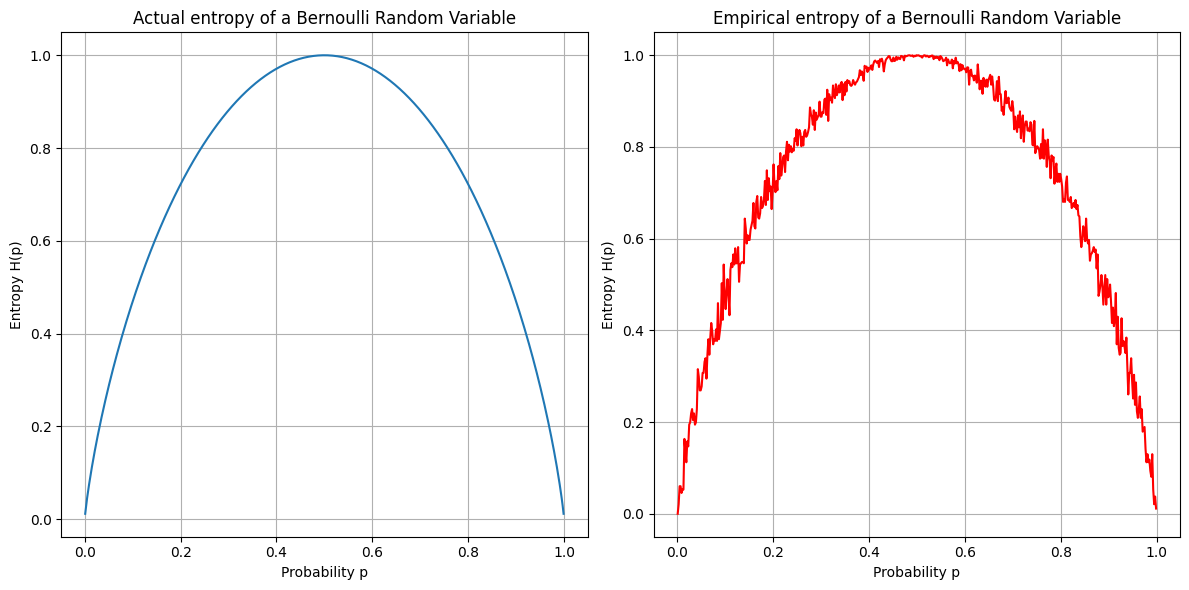

In [ ]:

p_values = np.linspace(0.001, 0.999, 500)

entropy_values = theoretical_bernoulli_entropy(p_values)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: Entropy as a function of p
axs[0].plot(p_values, entropy_values, label='Entropy H(p)')
axs[0].set_title('Actual entropy of a Bernoulli Random Variable')
axs[0].set_xlabel('Probability p')
axs[0].set_ylabel('Entropy H(p)')
axs[0].grid(True)

# Calculate empirical entropies by generating random samples from binomial (just corresponds to several bernoulli trials)
empirical_entropies = np.array([empirical_entropy(np.random.binomial(1, p, 1000)) for p in p_values])

# Second subplot: Empirical entropy as a function of p
axs[1].plot(p_values, empirical_entropies, label='1 - p', color='r')
axs[1].set_title('Empirical entropy of a Bernoulli Random Variable')
axs[1].set_xlabel('Probability p')
axs[1].set_ylabel('Entropy H(p)')
axs[1].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

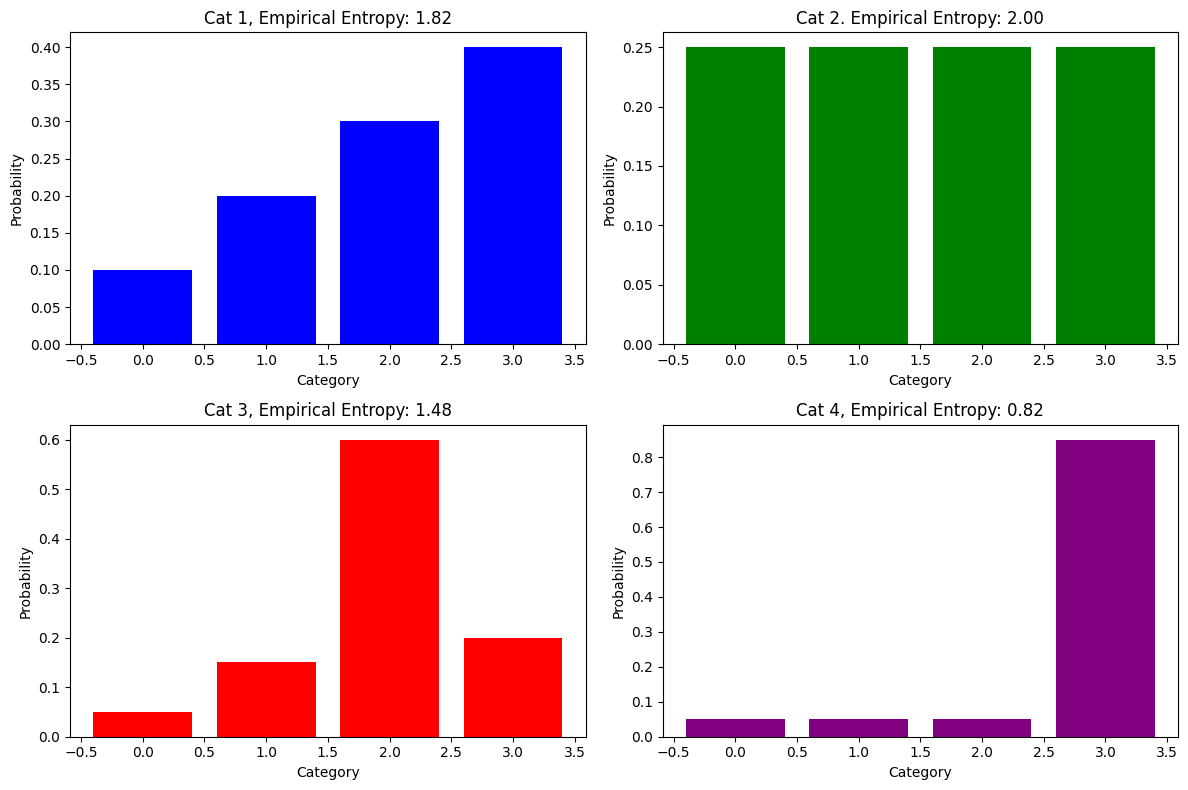

In [ ]:
# Now calculate empirical entropy for a few different categorical distributions:

import numpy as np
import matplotlib.pyplot as plt

# Define a few categorical distributions - Feel free to replace some of these with your own!
cat1 = np.array([0.1, 0.2, 0.3, 0.4])  # 4 categories
cat2 = np.array([0.25, 0.25, 0.25, 0.25])  # Uniform distribution
cat3 = np.array([0.05, 0.15, 0.6, 0.2])  # Skewed towards category 3
cat4 = np.array([0.05, 0.05, 0.05, 0.85])  # Dominated by category 4

categories = np.arange(4)

# Draw samples and calculate entropy
cat_1_samples = np.random.choice(categories,size=1000, p=cat1)
cat_2_samples = np.random.choice(categories,size=1000, p=cat2)
cat_3_samples = np.random.choice(categories,size=1000, p=cat3)
cat_4_samples = np.random.choice(categories,size=1000, p=cat4)

cat_1_entropy = empirical_entropy(cat_1_samples)
cat_2_entropy = empirical_entropy(cat_2_samples)
cat_3_entropy = empirical_entropy(cat_3_samples)
cat_4_entropy = empirical_entropy(cat_4_samples)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].bar(categories, cat1, color='b')
axs[0, 0].set_title(f'Cat 1, Empirical Entropy: {cat_1_entropy:.2f}')
axs[0, 0].set_xlabel('Category')
axs[0, 0].set_ylabel('Probability')

axs[0, 1].bar(categories, cat2, color='g')
axs[0, 1].set_title(f'Cat 2. Empirical Entropy: {cat_2_entropy:.2f}')
axs[0, 1].set_xlabel('Category')
axs[0, 1].set_ylabel('Probability')

axs[1, 0].bar(categories, cat3, color='r')
axs[1, 0].set_title(f'Cat 3, Empirical Entropy: {cat_3_entropy:.2f}')
axs[1, 0].set_xlabel('Category')
axs[1, 0].set_ylabel('Probability')

axs[1, 1].bar(categories, cat4, color='purple')
axs[1, 1].set_title(f'Cat 4, Empirical Entropy: {cat_4_entropy:.2f}')
axs[1, 1].set_xlabel('Category')
axs[1, 1].set_ylabel('Probability')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



## 6. **Cross-entropy

Now, we assume you at least have an idea of what entropy, lets move on to Cross-entropy, which looks much like the entropy:

$$H(p, q) = - \sum^N_{i = 1} p(x_i) \log(q(x_i))$$

What really changed? With the regular formula for entropy we compare a variable's probabilities to the log of themselves. Now, we compare the values of one probability distribution, $p$, to the values of a another probability distribution $q$.

We do not show it explicitly, but assume we have some random variable $X$, whose true probability distribution $p$ we attempt to approximate with some other probability distribution $q$.

Why is this useful? Two reasons mainly:

1. It gives us a very intuitive way of evaluating the performance of models that output probability distributions for classification, like neural networks.
2. It has some nice mathematical properties that directly ties it to multinomial logistic regression. (Which also gives it the cursed name of **"Negative Binomial Log-Likelihood"** (please don't ever call it that, it is the **Cross-Entropy**))


Because of its properties (hereunder, its relation to the "Kulbach-Liebler (KL) Divergence"), the cross-entropy can be seen as measuring the "total cost" of representing $p$ (the correct probability distribution) with $q$ (the approximate probability distribution)... optimal for modelling in ML. Why the **total** cost? Because the cross-entropy (unlike the KL-divergence) incorporates the intrinsic entropy of the variable in question. 

### Exercise 6.1

**1. Below, we once more have a couple of categorical distributions, but this time, we also calculate the cross entropy if another 5th distribution is used to approximate them. Explain the following:**

**- a. In general, what contributes to higher values of the cross entropy?**

**- b. Can we reasonably expect any of the original categorical distributions to always have a higher cross entropy, no matter what distribution we use to approximate it?**

**- c. Now subtract each distribution's entropy from the resulting cross-entropy, what do the results show? What do you think this means?**

In [ ]:
def theoretical_cross_entropy(p, q):
    return -np.sum(p * np.log2(q))

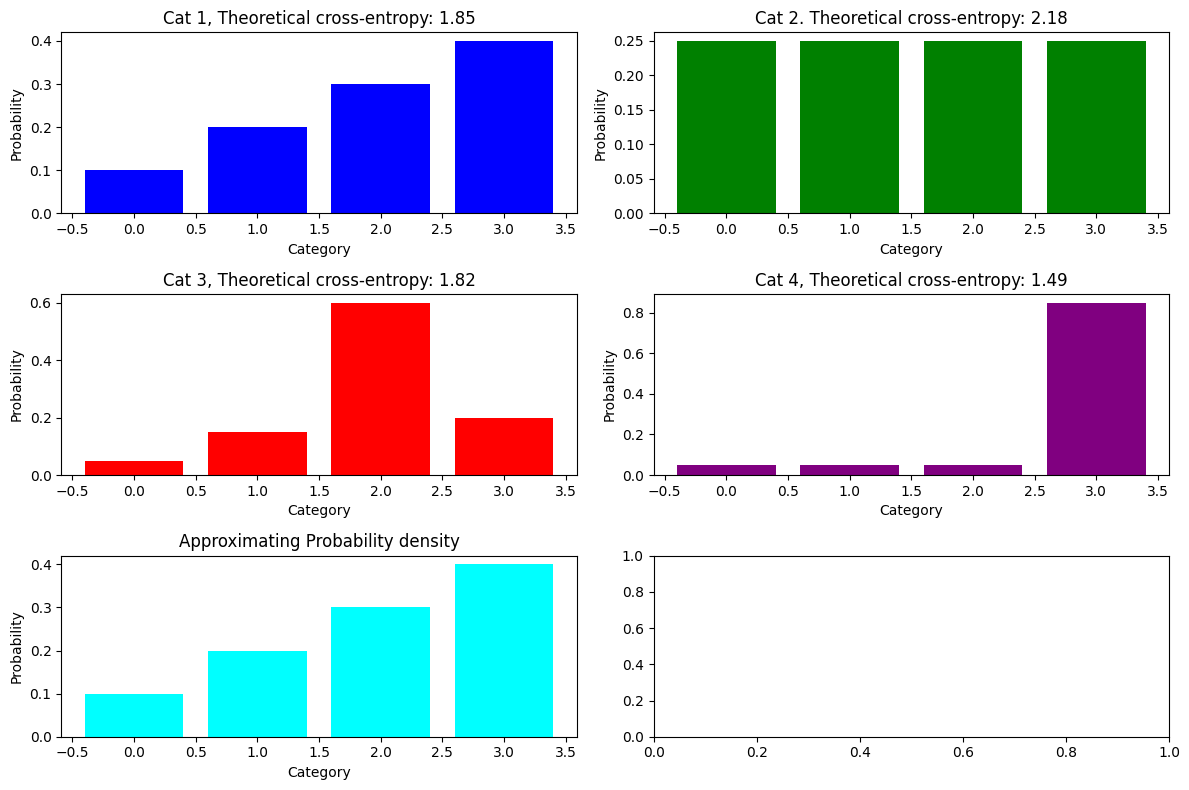

In [ ]:

# Approximating distribtion - We will use this to calculate the cross entropy
cat_approx = np.array([0.1, 0.2, 0.3, 0.4])

# Define a few categorical distributions - Feel free to replace some of these with your own!
cat1 = np.array([0.1, 0.2, 0.3, 0.4])  # 4 categories
cat2 = np.array([0.25, 0.25, 0.25, 0.25])  # Uniform distribution
cat3 = np.array([0.05, 0.15, 0.6, 0.2])  # Skewed towards category 3
cat4 = np.array([0.05, 0.05, 0.05, 0.85])  # Dominated by category 4

categories = np.arange(4)

# Draw samples and calculate entropy

cat_1_cr = theoretical_cross_entropy(cat1, cat_approx)
cat_2_cr = theoretical_cross_entropy(cat2, cat_approx)
cat_3_cr = theoretical_cross_entropy(cat3, cat_approx)
cat_4_cr = theoretical_cross_entropy(cat4, cat_approx)

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

axs[0, 0].bar(categories, cat1, color='b')
axs[0, 0].set_title(f'Cat 1, Theoretical cross-entropy: {cat_1_cr:.2f}')
axs[0, 0].set_xlabel('Category')
axs[0, 0].set_ylabel('Probability')

axs[0, 1].bar(categories, cat2, color='g')
axs[0, 1].set_title(f'Cat 2. Theoretical cross-entropy: {cat_2_cr:.2f}')
axs[0, 1].set_xlabel('Category')
axs[0, 1].set_ylabel('Probability')

axs[1, 0].bar(categories, cat3, color='r')
axs[1, 0].set_title(f'Cat 3, Theoretical cross-entropy: {cat_3_cr:.2f}')
axs[1, 0].set_xlabel('Category')
axs[1, 0].set_ylabel('Probability')

axs[1, 1].bar(categories, cat4, color='purple')
axs[1, 1].set_title(f'Cat 4, Theoretical cross-entropy: {cat_4_cr:.2f}')
axs[1, 1].set_xlabel('Category')
axs[1, 1].set_ylabel('Probability')

axs[2, 0].bar(categories, cat_approx, color='cyan')
axs[2, 0].set_title(f'Approximating Probability density')
axs[2, 0].set_xlabel('Category')
axs[2, 0].set_ylabel('Probability')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Empirical Cross-entropy

When calculating cross-entropy for classifiers such as neural networks and multinomial logistic regression, we usually do not have the correct class probabilities $p$, but we do still have our approximate class probabilities $q$. As such, we simply change the class probabiltiies $p$ slightly, to simply be a one-hot vector, indicating what the correct class is. Our formula remains the same, but our probabilities look slighlty different:

$$
q_i = 
\begin{bmatrix}
    p_1 \\
    p_2  \\
    \vdots \\
    p_k \\
\end{bmatrix},

p_i =
\begin{bmatrix}
    0 \\
    1  \\
    \vdots \\
    0 \\
\end{bmatrix}
$$

Above shown in an example where the class of datapoint $i = 2$

This is a necessary distinction, as we have no simply way of making a "counterfactual" question asking "What is the probability that the datapoint $i$ would actually be representing as another class c?". This of course comes with its own host of quirks and downsides, one example being potentially pushing predictions towards extreme overconfidence, always predicting things with 100% accuracy, but in general, it works well enough that we still use it.

Bear in mind, many other explanations, like those on the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), for example, also include batch dimensions, which can change the formula just a little bit.